<a href="https://colab.research.google.com/github/ARBasharat/AudioClassification/blob/master/AudioClassification1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contact: abbash@iu.edu <br/>
Audio Classification after augmenting training data

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
import librosa
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

# Load Data from Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

train = np.load("drive/My Drive/AudioClassification/audio_train.npy").astype('float32')
test = np.load("drive/My Drive/AudioClassification/audio_test.npy").astype('float32')
train_labels_df = pd.read_csv("drive/My Drive/AudioClassification/labels_train.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Process Data

In [3]:
train_labels = train_labels_df.to_numpy()[:,1]
labels_categorical = keras.utils.to_categorical(train_labels)

X_train_original, X_val_original, y_train_original, y_val = train_test_split(train, 
                          labels_categorical, test_size=0.20, random_state=42)

print("Training Data:", X_train_original.shape)
print("Training Labels:", y_train_original.shape)
print("Validation Data:", X_val_original.shape)
print("Validation Labels:", y_val.shape)
print("Testing Data:", test.shape)

Training Data: (753, 30000)
Training Labels: (753, 10)
Validation Data: (189, 30000)
Validation Labels: (189, 10)
Testing Data: (558, 30000)


In [4]:
## We switch between white and normal noise randomly

def add_white_noise(data, rate = 0.05):
  data_with_white_noise = data + rate * np.random.randn(len(data))
  return data_with_white_noise

'''
Noise addition using normal distribution with mean = 0 and std =1
Permissible noise factor value = x > 0.004
'''
def add_normal_distributed_noise(data, rate = 0.09, sr = 30000):
  data_with_noramlized_noise = data + rate * np.random.normal(0, 1, len(data))
  return data_with_noramlized_noise

'''
Time Shifting
Permissible factor values = sr/10
'''
def add_time_shift(data, sr = 30000):
  data_with_time_shift = np.roll(data, int(sr/10))
  return data_with_time_shift

'''
Pitch shifting
Permissible factor values = -5 <= x <= 5
'''
def add_pitch_shift(data, sr = 30000, steps = -7):
  data_with_pitch_shift = librosa.effects.pitch_shift(data, sr, n_steps = steps)
  return data_with_pitch_shift

In [5]:
# Get augmented_training data equal to size of real data
def get_augmented_data_two_times(X_train_original, y_train_original):
  new_data = []
  new_labels = []
  for i in range(0, len(X_train_original)):
    data = X_train_original[i]
    label = y_train_original[i]
    choice = random.choice([1, 2, 3, 4]) ## Used for selecting between white noise and normalized noise
    ## get augmented data
    new_data.append(data)
    if choice == 1:
      new_data.append(add_white_noise(data))
    elif choice == 2:
      new_data.append(add_normal_distributed_noise(data))
    elif choice == 3:
      new_data.append(add_time_shift(data))
    elif choice == 4:
      new_data.append(add_pitch_shift(data))
    ## get labels
    new_labels.append(label)
    new_labels.append(label)

  ## Get augmented train data and labels
  train_data = np.array(new_data)
  y_train = np.array(new_labels)
  return train_data, y_train

train_data, y_train = get_augmented_data_two_times(X_train_original, y_train_original)
print(train_data.shape, y_train.shape)

(1506, 30000) (1506, 10)


In [6]:
train_data /= train_data.max()
X_val_original /= X_val_original.max()
test /= test.max()

In [7]:
X_train = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
X_val = X_val_original.reshape((X_val_original.shape[0], X_val_original.shape[1], 1))
X_test = test.reshape((test.shape[0], test.shape[1], 1))
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape)

(1506, 30000, 1) (189, 30000, 1) (558, 30000, 1) (1506, 10) (189, 10)


# Define Models

In [8]:
## Base Model Architecture 
def getBaseModel():
  model = models.Sequential()
  model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(30000, 1)))
  model.add(layers.MaxPooling1D(2))
  model.add(layers.Conv1D(64, 3, activation='relu'))
  model.add(layers.MaxPooling1D(2))
  model.add(layers.Conv1D(128, 3, activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  model.summary()
  return model

def get_model_2():
  model = tf.keras.models.Sequential()
  model.add(layers.Conv1D(32, kernel_size=3, activation='relu', 
                    input_shape=(30000, 1)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv1D(48, kernel_size=3, activation='relu'))
  model.add(layers.Conv1D(120, kernel_size=3, activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Dropout(0.25))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(10, activation='softmax'))
  return model

def get_model_3():
  model = tf.keras.models.Sequential()
  model.add(layers.Conv1D(32, kernel_size=3, activation='relu', 
                    input_shape=(30000, 1)))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Dropout(0.25))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(10, activation='softmax'))
  return model

In [9]:
## Compile and Train Model with Early stopping
def compileModel(model, optimizer = 'adam', epochs = 10):
  earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  
  model.compile(optimizer=optimizer,
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])
  
  history = model.fit(X_train, y_train, epochs=epochs, verbose=2, batch_size=64,
          validation_data=(X_val, y_val), callbacks=earlyStopping)
  
  return history

## Plot Training History
def plotTrainingAccuracy(history):
  plt.figure()
  plt.plot(history.history['accuracy'], label='training_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='upper left')
  plt.show()
  plt.close()

def plotTrainingLoss(history):
  plt.figure()
  plt.plot(history.history['loss'], label='training_loss')
  plt.plot(history.history['val_loss'], label = 'validation_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='upper left')
  plt.show()
  plt.close()

## Evaluate the model
def predictModel(model, test):
  return model.predict_classes(test, verbose=0)
  

## Evaluate the model
def evaluateModel(model, X_test, y_test):
  test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
  print("\n ### Performance of Test Data ###")
  print("Validation Accuracy: ", test_acc)
  print("Validation Loss: ", test_loss, "\n")

# Train Model 1

In [18]:
model = getBaseModel()
history = compileModel(model, optimizer = 'adam', epochs = 100)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 29998, 32)         128       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 14999, 32)         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 14997, 64)         6208      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7498, 64)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 7496, 128)         24704     
_________________________________________________________________
flatten_2 (Flatten)          (None, 959488)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

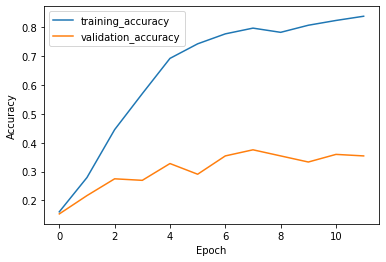

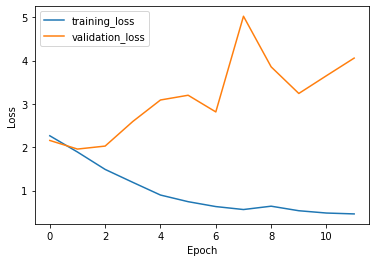


 ### Performance of Test Data ###
Validation Accuracy:  0.35449734330177307
Validation Loss:  4.058623313903809 



In [19]:
plotTrainingAccuracy(history)
plotTrainingLoss(history)
evaluateModel(model, X_val, y_val)

In [20]:
predictions = predictModel(model, X_test)
predictions

array([9, 9, 4, 1, 7, 5, 9, 3, 6, 7, 4, 7, 7, 8, 0, 7, 7, 7, 7, 3, 7, 7,
       7, 7, 3, 5, 7, 5, 0, 1, 3, 7, 8, 7, 6, 3, 7, 0, 9, 9, 7, 3, 5, 9,
       3, 0, 3, 1, 3, 7, 7, 6, 3, 0, 8, 3, 5, 7, 4, 0, 7, 3, 8, 7, 0, 7,
       3, 7, 3, 3, 3, 9, 0, 4, 0, 5, 9, 7, 7, 3, 7, 1, 3, 7, 5, 3, 3, 7,
       4, 7, 0, 9, 0, 9, 3, 1, 7, 7, 7, 7, 7, 3, 7, 7, 0, 3, 1, 4, 7, 7,
       6, 3, 7, 5, 1, 9, 1, 5, 5, 1, 7, 9, 3, 7, 1, 7, 7, 5, 1, 9, 7, 3,
       7, 8, 3, 7, 4, 3, 4, 4, 7, 5, 5, 4, 7, 3, 0, 0, 1, 5, 7, 0, 5, 7,
       3, 9, 3, 7, 5, 0, 3, 8, 7, 7, 7, 1, 6, 3, 4, 0, 8, 7, 8, 3, 6, 8,
       3, 0, 3, 5, 7, 7, 7, 7, 4, 4, 7, 1, 3, 3, 9, 7, 7, 4, 8, 8, 9, 5,
       7, 7, 5, 7, 7, 4, 7, 8, 7, 9, 4, 3, 9, 7, 5, 9, 9, 7, 7, 4, 3, 7,
       9, 0, 1, 7, 7, 5, 8, 5, 1, 7, 3, 7, 7, 5, 7, 8, 6, 3, 3, 0, 4, 9,
       6, 7, 8, 5, 7, 7, 9, 8, 7, 0, 3, 8, 0, 5, 4, 3, 7, 7, 7, 7, 1, 6,
       3, 3, 5, 3, 7, 4, 1, 3, 3, 6, 3, 7, 1, 7, 9, 7, 1, 5, 4, 3, 8, 7,
       7, 7, 0, 3, 7, 0, 7, 7, 0, 7, 7, 3, 8, 0, 4,

In [21]:
pd.DataFrame(predictions).to_csv("submission.csv")

# Train Model 1

In [10]:
model_2 = get_model_2()
history_2 = compileModel(model_2, optimizer = 'adam', epochs = 100)

Epoch 1/100
24/24 - 9s - loss: 2.4545 - accuracy: 0.1202 - val_loss: 2.2482 - val_accuracy: 0.1323
Epoch 2/100
24/24 - 9s - loss: 2.2647 - accuracy: 0.1275 - val_loss: 2.2392 - val_accuracy: 0.1217
Epoch 3/100
24/24 - 9s - loss: 2.2082 - accuracy: 0.1534 - val_loss: 2.1508 - val_accuracy: 0.1852
Epoch 4/100
24/24 - 9s - loss: 2.1283 - accuracy: 0.1833 - val_loss: 2.1066 - val_accuracy: 0.1640
Epoch 5/100
24/24 - 9s - loss: 1.9627 - accuracy: 0.2583 - val_loss: 2.0229 - val_accuracy: 0.2011
Epoch 6/100
24/24 - 9s - loss: 1.8148 - accuracy: 0.3214 - val_loss: 2.0492 - val_accuracy: 0.2116
Epoch 7/100
24/24 - 9s - loss: 1.7113 - accuracy: 0.3473 - val_loss: 2.0966 - val_accuracy: 0.2275
Epoch 8/100
24/24 - 9s - loss: 1.6478 - accuracy: 0.3765 - val_loss: 1.9963 - val_accuracy: 0.2540
Epoch 9/100
24/24 - 9s - loss: 1.5222 - accuracy: 0.4582 - val_loss: 2.0697 - val_accuracy: 0.2910
Epoch 10/100
24/24 - 9s - loss: 1.4264 - accuracy: 0.4980 - val_loss: 2.0606 - val_accuracy: 0.3069
Epoch 11/

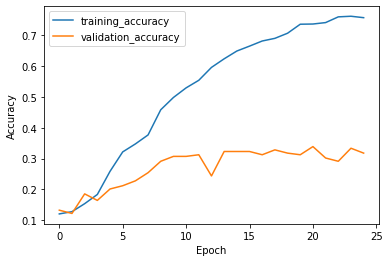

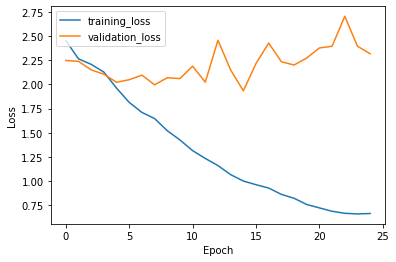


 ### Performance of Test Data ###
Validation Accuracy:  0.3174603283405304
Validation Loss:  2.3173370361328125 



In [11]:
plotTrainingAccuracy(history_2)
plotTrainingLoss(history_2)
evaluateModel(model_2, X_val, y_val)

In [12]:
predictions = predictModel(model_2, X_test)
predictions

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([9, 9, 4, 1, 5, 5, 9, 1, 0, 9, 4, 7, 8, 8, 1, 3, 4, 4, 7, 1, 4, 7,
       7, 7, 4, 7, 9, 5, 0, 1, 3, 1, 8, 7, 6, 0, 7, 1, 9, 9, 6, 0, 1, 9,
       7, 3, 6, 1, 3, 6, 7, 6, 4, 0, 8, 3, 8, 6, 4, 0, 7, 3, 8, 9, 0, 0,
       1, 6, 0, 3, 0, 7, 0, 4, 0, 8, 9, 7, 1, 5, 6, 1, 6, 7, 4, 6, 6, 7,
       9, 6, 0, 8, 0, 7, 3, 1, 3, 7, 7, 6, 7, 3, 1, 7, 3, 3, 1, 1, 7, 7,
       6, 1, 4, 5, 0, 8, 1, 5, 5, 4, 8, 0, 0, 1, 1, 0, 6, 6, 4, 9, 7, 3,
       7, 3, 3, 7, 4, 4, 7, 4, 4, 7, 5, 8, 3, 0, 0, 0, 1, 8, 7, 0, 5, 6,
       3, 5, 3, 7, 1, 1, 6, 6, 7, 7, 7, 6, 6, 3, 7, 0, 5, 0, 8, 3, 6, 8,
       3, 0, 6, 8, 9, 4, 7, 7, 7, 4, 7, 3, 0, 3, 6, 7, 7, 4, 3, 8, 8, 7,
       7, 7, 5, 7, 7, 7, 6, 4, 7, 9, 6, 3, 0, 1, 9, 9, 5, 7, 7, 4, 3, 7,
       9, 0, 1, 7, 7, 8, 8, 7, 8, 7, 0, 7, 7, 5, 7, 8, 6, 7, 3, 3, 6, 5,
       6, 7, 5, 5, 7, 7, 1, 3, 7, 0, 3, 8, 0, 7, 4, 3, 7, 7, 7, 7, 5, 6,
       4, 3, 7, 3, 7, 4, 8, 9, 3, 6, 3, 6, 1, 7, 9, 7, 1, 1, 4, 6, 3, 7,
       6, 8, 3, 3, 7, 1, 7, 7, 0, 7, 7, 3, 5, 6, 8,

In [13]:
pd.DataFrame(predictions).to_csv("submission_2.csv")

# Train Model 3

In [14]:
model_3 = get_model_3()
history_3 = compileModel(model_3, optimizer = 'adam', epochs = 100)

Epoch 1/100
24/24 - 4s - loss: 2.3545 - accuracy: 0.1235 - val_loss: 2.2505 - val_accuracy: 0.0847
Epoch 2/100
24/24 - 4s - loss: 2.2556 - accuracy: 0.1248 - val_loss: 2.2350 - val_accuracy: 0.1111
Epoch 3/100
24/24 - 4s - loss: 2.2249 - accuracy: 0.1448 - val_loss: 2.1973 - val_accuracy: 0.1323
Epoch 4/100
24/24 - 4s - loss: 2.1710 - accuracy: 0.1434 - val_loss: 2.1525 - val_accuracy: 0.1640
Epoch 5/100
24/24 - 4s - loss: 2.1329 - accuracy: 0.1786 - val_loss: 2.1367 - val_accuracy: 0.1534
Epoch 6/100
24/24 - 4s - loss: 2.0585 - accuracy: 0.2125 - val_loss: 2.0676 - val_accuracy: 0.2011
Epoch 7/100
24/24 - 4s - loss: 1.9460 - accuracy: 0.2523 - val_loss: 1.9994 - val_accuracy: 0.2487
Epoch 8/100
24/24 - 4s - loss: 1.7814 - accuracy: 0.3267 - val_loss: 1.9277 - val_accuracy: 0.2698
Epoch 9/100
24/24 - 4s - loss: 1.6303 - accuracy: 0.4004 - val_loss: 1.8889 - val_accuracy: 0.3228
Epoch 10/100
24/24 - 4s - loss: 1.4875 - accuracy: 0.4542 - val_loss: 1.8155 - val_accuracy: 0.3439
Epoch 11/

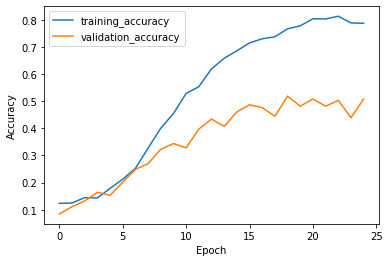

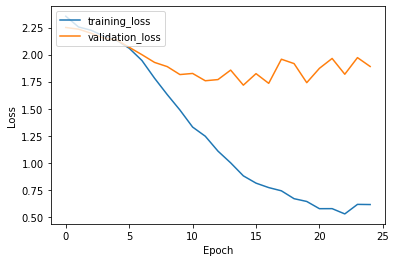


 ### Performance of Test Data ###
Validation Accuracy:  0.5079365372657776
Validation Loss:  1.8900771141052246 



In [15]:
plotTrainingAccuracy(history_3)
plotTrainingLoss(history_3)
evaluateModel(model_3, X_val, y_val)

In [16]:
predictions = predictModel(model_3, X_test)
predictions

array([5, 9, 4, 1, 7, 5, 9, 9, 0, 0, 8, 0, 9, 8, 0, 6, 7, 7, 5, 9, 7, 3,
       8, 3, 3, 5, 7, 4, 0, 1, 7, 4, 8, 3, 6, 9, 8, 0, 9, 9, 3, 9, 5, 1,
       1, 0, 3, 9, 3, 7, 8, 6, 1, 0, 8, 3, 5, 3, 7, 0, 3, 6, 8, 6, 9, 0,
       1, 6, 3, 3, 3, 1, 0, 5, 9, 5, 9, 3, 9, 5, 9, 1, 6, 9, 5, 0, 3, 0,
       9, 6, 0, 8, 0, 8, 8, 1, 6, 3, 3, 3, 0, 4, 1, 7, 0, 3, 1, 4, 8, 8,
       1, 9, 5, 5, 9, 0, 9, 5, 5, 4, 5, 0, 0, 7, 1, 0, 3, 5, 1, 9, 8, 7,
       3, 0, 7, 3, 1, 9, 5, 1, 7, 8, 5, 5, 1, 0, 9, 9, 1, 5, 3, 0, 5, 3,
       7, 9, 3, 9, 1, 9, 3, 3, 3, 3, 3, 1, 6, 6, 5, 0, 5, 0, 8, 8, 6, 0,
       3, 9, 6, 5, 5, 9, 8, 7, 8, 1, 6, 1, 9, 1, 9, 6, 1, 4, 8, 8, 5, 5,
       3, 0, 5, 5, 7, 8, 6, 1, 9, 9, 6, 3, 9, 9, 5, 9, 9, 3, 3, 5, 9, 3,
       9, 0, 1, 3, 6, 5, 8, 5, 1, 9, 7, 0, 3, 5, 9, 8, 6, 8, 3, 9, 6, 5,
       6, 7, 8, 5, 8, 6, 9, 8, 8, 0, 6, 8, 0, 5, 4, 7, 3, 3, 3, 3, 7, 8,
       3, 6, 5, 3, 5, 8, 6, 9, 3, 1, 3, 3, 1, 8, 9, 1, 1, 5, 7, 4, 8, 3,
       3, 4, 0, 6, 3, 9, 7, 8, 9, 3, 8, 3, 4, 0, 8,

In [17]:
pd.DataFrame(predictions).to_csv("submission_3.csv")